In [1]:
import tensorflow as tf
import numpy as np
import numpy.random as rnd
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)


In [2]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005,
                      activation=tf.nn.elu, seed=42):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        my_dense_layer = partial(
            tf.layers.dense,
            activation=activation,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=None, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            for iteration in range(n_batches):
                #print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            if epoch % 500 == 0:
                print("\r{}".format(epoch), "Train MSE:", loss_train)
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

In [3]:
x_train = np.genfromtxt('data/data_wt/sp500_wt.csv', delimiter=',', dtype=None, names=True)
x_train = [list(item) for item in x_train]
x_train = np.array(x_train)
print(x_train.shape)

(2079, 21)


In [4]:
def normalise_dataset(dataset):
    n_cols = dataset.shape[1]
    norm_dataset = np.zeros_like(dataset)
    for i in range(n_cols): 
        mean = np.sum(dataset[:,i])/len(dataset[:,i])
        std_dev = np.dot(dataset[:,i]-mean, dataset[:,i]-mean)/(len(dataset[:,i]) - 1)
        std_dev = np.sqrt(std_dev)
        norm_dataset[:,i] = (dataset[:,i] - mean) / std_dev

    return norm_dataset

# Normalised dataset
x_train = normalise_dataset(x_train)

In [5]:
# check this 
BATCH_SIZE = 60
N_EPOCHS = 5000
ACTIVATION = tf.nn.relu
LEARNING_RATE = 0.005

hidden_output1, W1, b1, W8, b8 = train_autoencoder(x_train, n_neurons=50, 
                                                   n_epochs=N_EPOCHS, 
                                                   batch_size=BATCH_SIZE, 
                                                   learning_rate=LEARNING_RATE,
                                                   activation=ACTIVATION)
hidden_output2, W2, b2, W7, b7 = train_autoencoder(hidden_output1, n_neurons=30, 
                                                   n_epochs=N_EPOCHS, 
                                                   batch_size=BATCH_SIZE, 
                                                   learning_rate=LEARNING_RATE,
                                                   activation=ACTIVATION)
hidden_output3, W3, b3, W6, b6 = train_autoencoder(hidden_output2, n_neurons=20, 
                                                   n_epochs=N_EPOCHS, 
                                                   batch_size=BATCH_SIZE, 
                                                   learning_rate=LEARNING_RATE,
                                                   activation=ACTIVATION)
o4, W4, b4, W5, b5 = train_autoencoder(hidden_output3,n_neurons=10, 
                                                   n_epochs=N_EPOCHS, 
                                                   batch_size=BATCH_SIZE, 
                                                   learning_rate=LEARNING_RATE,
                                                   activation=ACTIVATION)

0 Train MSE: 0.185488
500 Train MSE: 0.000546614
1000 Train MSE: 0.00039945
1500 Train MSE: 0.000534147
2000 Train MSE: 0.000406173
2500 Train MSE: 0.000452525
3000 Train MSE: 0.000676329
3500 Train MSE: 0.000473096
4000 Train MSE: 0.000411585
4500 Train MSE: 0.000433776
0 Train MSE: 0.49118
500 Train MSE: 0.000449119
1000 Train MSE: 0.000516467
1500 Train MSE: 0.000466427
2000 Train MSE: 0.00060745
2500 Train MSE: 0.000377359
3000 Train MSE: 0.000566011
3500 Train MSE: 0.000452644
4000 Train MSE: 0.000428649
4500 Train MSE: 0.000405135
0 Train MSE: 0.914629
500 Train MSE: 0.000452118
1000 Train MSE: 0.000416644
1500 Train MSE: 0.00044399
2000 Train MSE: 0.000607588
2500 Train MSE: 0.000475552
3000 Train MSE: 0.0004241
3500 Train MSE: 0.00054936
4000 Train MSE: 0.000404773
4500 Train MSE: 0.000408764
0 Train MSE: 2.36133
500 Train MSE: 0.0161436
1000 Train MSE: 0.0116998
1500 Train MSE: 0.0137815
2000 Train MSE: 0.0143039
2500 Train MSE: 0.0120811
3000 Train MSE: 0.0123962
3500 Train M

In [6]:
reset_graph()

n_inputs = 1*21

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.relu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.relu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.relu(tf.matmul(hidden2, W3) + b3)
hidden4 = tf.nn.relu(tf.matmul(hidden3, W4) + b4)
hidden5 = tf.nn.relu(tf.matmul(hidden4, W5) + b5)
hidden6 = tf.nn.relu(tf.matmul(hidden5, W6) + b6)
hidden7 = tf.nn.relu(tf.matmul(hidden6, W7) + b7)
outputs = tf.matmul(hidden7, W8) + b8

In [7]:
#unnecessary - should be the same as o4 but just to check
with tf.Session() as sess:
        latent_val = hidden4.eval(feed_dict={X: x_train})
        
# Normalise output of SAEs
latent_val = normalise_dataset(latent_val)

In [8]:
import pandas as pd
latent_out = pd.DataFrame(latent_val).head() #latent_val
latent_out

,0,1,2,3,4,5,6,7,8,9
0,1.958050,0.842062,5.205854,-0.240776,-0.065999,-0.175180,-0.139260,-0.913391,1.328064,-1.030322
1,1.958042,0.842094,5.205704,-0.240876,-0.066099,-0.175256,-0.139256,-0.913372,1.328120,-1.030218
2,1.958032,0.842126,5.205555,-0.240975,-0.066200,-0.175333,-0.139252,-0.913354,1.328176,-1.030114
3,1.957996,0.842258,5.204957,-0.241373,-0.066601,-0.175638,-0.139236,-0.913281,1.328404,-1.029696
4,1.801892,1.352323,5.250746,0.282344,0.170007,-1.117460,0.438896,-0.373465,0.660157,-1.014384


In [9]:
# Save output in .csv file
latent_out.to_csv('auto_out.csv', header=False, index=False)

In [10]:
reset_graph()
import keras
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import LSTM, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [11]:
# convert an array of values into a dataset matrix
def create_dataset(trainX, trainY, look_back=1):
    dataX, dataY = [], []
    for i in range(len(trainX)-look_back-1):
        a = trainX[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(trainY[i + look_back])
    return np.array(dataX), np.array(dataY)

In [12]:
from IPython.display import clear_output

# Live plot for loss during training
# Taken from: https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        # Reset the plot to only have the last 100 epochs
        if len(self.x) % 100 == 0:
            self.on_train_begin()
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [13]:
y_lazy = pd.read_csv('data/sp500_index_data.csv')['Close Price']
y_train = y_lazy.shift(-1)

#this means we have an na for the last value training is latent_val, target y_train
#get the saved latent values

In [15]:
#latent_val = np.array(pd.read_csv('sae_output_5000.csv'))
latent_val.shape

(2079, 10)

In [1]:
look_back =4
trainX = latent_val[:-1]
trainX = trainX[:round(0.9*len(trainX))]
testX = trainX[round(0.9*len(trainX)):]

trainY = np.array(y_train[:-1])
trainY = trainY[:round(0.9*len(trainY))]
testY = trainY[round(0.9*len(trainY)):]

trainX, trainY = create_dataset(trainX, trainY, look_back)
testX, testY = create_dataset(testX, testY, look_back) 

NameError: name 'latent_val' is not defined

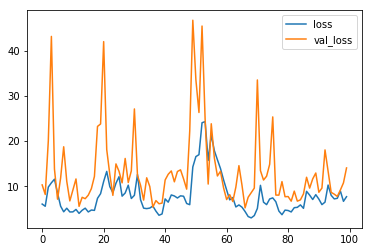

1865/1865 [==============================] - 0s - loss: 7.6770 - val_loss: 14.0418


In [17]:

# create and fit the LSTM network
LEARNING_RATE = 0.005
BATCH_SIZE = 50
EPOCHS = 2000
opti_adam = keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 10)))
#model.add(LSTM(20, input_shape=(look_back, 10)))
model.add(LSTM(20))



model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=opti_adam)
history = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=BATCH_SIZE,
          verbose=1, callbacks=[plot_losses], validation_data=(testX, testY))

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4, 50)             12200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 17,901
Trainable params: 17,901
Non-trainable params: 0
_________________________________________________________________


[[ 1244.31616211]
 [ 1252.5847168 ]
 [ 1237.30761719]
 ..., 
 [ 2078.9753418 ]
 [ 2102.35913086]
 [ 2076.9609375 ]]


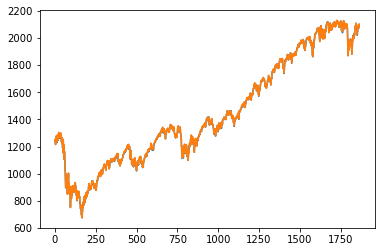

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
bugger = model.predict(trainX)
print(bugger)

plt.plot(bugger)
plt.plot(trainY)
plt.show()

[[ 2066.73461914]
 [ 2095.21875   ]
 [ 2090.04150391]
 [ 2110.89404297]
 [ 2105.87988281]
 [ 2088.8515625 ]
 [ 2061.41796875]
 [ 2056.05395508]
 [ 2064.17041016]
 [ 2083.96679688]
 [ 2063.62548828]
 [ 2058.28051758]
 [ 2062.86303711]
 [ 2073.17285156]
 [ 2072.57861328]
 [ 2078.26074219]
 [ 2092.25756836]
 [ 2098.86108398]
 [ 2091.02539062]
 [ 2097.11181641]
 [ 2109.18383789]
 [ 2107.49487305]
 [ 2086.04785156]
 [ 2100.95239258]
 [ 2099.30297852]
 [ 2112.92749023]
 [ 2115.31469727]
 [ 2117.33276367]
 [ 2107.51708984]
 [ 2113.04614258]
 [ 2106.82421875]
 [ 2086.39550781]
 [ 2103.50732422]
 [ 2102.74951172]
 [ 2088.81616211]
 [ 2083.9440918 ]
 [ 2084.72802734]
 [ 2101.96801758]
 [ 2104.76806641]
 [ 2100.15429688]
 [ 2099.51171875]
 [ 2117.64013672]
 [ 2123.75610352]
 [ 2125.82055664]
 [ 2125.72167969]
 [ 2125.6340332 ]
 [ 2125.59765625]
 [ 2125.62817383]
 [ 2108.17895508]
 [ 2122.33666992]
 [ 2120.73876953]
 [ 2109.59545898]
 [ 2110.06152344]
 [ 2109.49829102]
 [ 2110.73388672]
 [ 2090.85

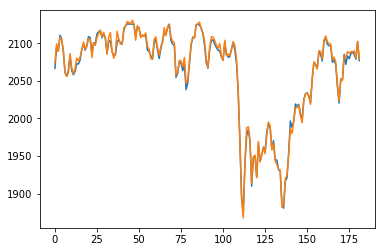

In [20]:
bugger_test = model.predict(testX)
print(bugger_test)
plt.plot(bugger_test)
plt.plot(testY)
plt.show()

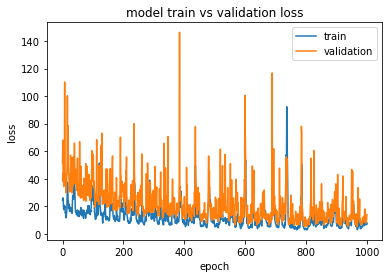

In [21]:
# plot train and validation loss
plt.plot(history.history['loss'][-1000:])
plt.plot(history.history['val_loss'][-1000:])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

1864
1864


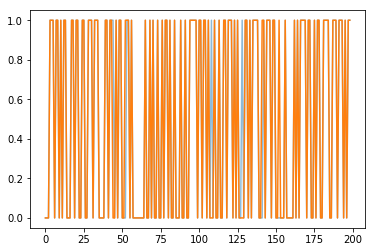

[ 1244.31616211  1252.5847168   1237.30761719 ...,  2078.9753418
  2102.35913086  2076.9609375 ]


In [22]:
diff_bugger = np.diff(bugger[:,0])
diff_bugger = [1 if x > 0 else 0 for x in diff_bugger]
diff_trainY = np.diff(trainY)
diff_trainY = [1 if x > 0 else 0 for x in diff_trainY]
print(len(diff_trainY))
print(len(diff_bugger))
plt.plot(diff_trainY[1:200], alpha = 0.5)
plt.plot(diff_bugger[1:200])
plt.show()
print(bugger[:,0])

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(diff_bugger, diff_trainY, labels=[0,1])

array([[789,  62],
       [ 60, 953]])

In [25]:
789+953


1742

In [26]:
60+62

122

In [27]:
1742/(1742+122)

0.9345493562231759